# Variational Auto Encoders for Cardiac Shape Modeling

**Supervisor:** Loïc Le Folgoc

**Group:**
* Alice Valença De Lorenci
* Artur Dandolini Pescador
* Giulia Mannaioli
* Lais Isabelle Alves dos Santos

## Objectives

The goal of this project is to implement a convolutional Variational Autoencoder (VAE) in order to build a mapping between a latent space of cardiac shape and 2D segmentation masks of the left ventricle, right ventricle and myocardium. More precisely, the input of the VAE are 4-channel 2D images, each image is the segmentation mask of one cardiac MRI slice and the channels correspond to the segmentation masks of the background, left ventricle, right ventricle and myocardium. The results will be evaluated in terms of the quality of the reconstruction of the segmentation masks.

The main articles consulted during the elaboration of the project were:
1. Biffi, C., et al. (2018) Learning interpretable anatomical features through deep generative models: Application to cardiac remodeling. *International conference on medical image computing and computer-assisted intervention*, 464-471.
2. Painchaud, N., et al. (2020) Cardiac Segmentation with Strong Anatomical Guarantees. *IEEE Transactions on Medical Imaging* 39(11), 3703-3713.

The first article was the main source of inspiration for the project while the architecture chosen for the VAE was based on the one presented in the second article.

This report is organized into the following sections:
- *Dataset*: Description of the dataset and the pre-processing steps.
- *VAE*: Implementation and description of the Variational Autoencoder.
- *Results*: Analysis of the quality of image reconstruction and generation.

Furthermore, the following files accompany the project:
- *preprocessing.py*: Implementation of the methods needed to load and pre-process the dataset.
- *model.py*: Class implementing the VAE architecture.
- *model_evaluation.py*: Implementation of the methods used to evaluate the VAE.

## Dataset

The dataset used for this project is that of the [ACDC challenge](https://www.creatis.insa-lyon.fr/Challenge/acdc/databases.html). It consists in a training-validation set of 100 subjects and a test set of 50 subjects, both sets were mixed and later randomly split into train, validation and test sets. For all subjects, both cardiac MRI images and the corresponding segmentation maps are provided for end systole (ES) and end diastole (ED), however only the ED images are be used. The segmentation map includes the following structures (with respective labels):

0. Background
1. Right ventricle cavity (RV)
2. Myocardium (MY)
3. Left ventricle cavity (LV)

In the cells bellow the python environment is set-up and the necessary packages are imported. Afterwards, the path to the folder containing the dataset is defined and the path to the images contained in the folder is determined.

In [1]:
# detect if it is running on colab
if 'google.colab' in str(get_ipython()):
  colab = True
else:
  colab = False

if colab:
  from google.colab import drive
  drive.mount('/content/drive', force_remount=True)

  import sys
  # path = '/content/drive/MyDrive/Variational-Auto-Encoders-for-cardiac-shape-modeling/'
  path = '/content/drive/MyDrive/Télécom/2A/IMA/IMA206/project/Variational-Auto-Encoders-for-cardiac-shape-modeling/'
  # path = '/content/drive/MyDrive/2022-2A/IMA206/project/'
  # path = '/content/drive/MyDrive/ima206-project/'
  sys.path.insert(0,path)

  try:
    import torchio
  except:
    import locale
    locale.getpreferredencoding = lambda: "UTF-8"
    !pip install torchio
else:
  path = ''

Mounted at /content/drive
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.9/172.9 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 237.5/237.5 kB 29.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.1/51.1 kB 7.1 MB/s eta 0:00:00
  Attempting uninstall: rich
    Found existing installation: rich 13.4.2
    Uninstalling rich-13.4.2:
      Successfully uninstalled rich-13.4.2


In [2]:
# necessary libraries
import os
import nibabel as nib
import numpy as np
import torch
import torch.utils.data as torch_data

import preprocessing as pre
import model as m
import model_evaluation as eval

from IPython.display import Image

In [3]:
# if the .py is changed, run to reload
import importlib
importlib.reload(m)
importlib.reload(eval)
importlib.reload(pre)

<module 'preprocessing' from '/content/drive/MyDrive/Télécom/2A/IMA/IMA206/project/Variational-Auto-Encoders-for-cardiac-shape-modeling/preprocessing.py'>

In [4]:
# Path to folder containing the dataset
if os.path.exists(path+'../ACDC/database'):
    dataset_path = path+'../ACDC/database'
elif os.path.exists(path+'./ACDC/database'):
    dataset_path = path+'./ACDC/database'
else:
    raise Exception('Define path to dataset')

testing_folder = os.path.join(dataset_path, 'testing')
training_folder = os.path.join(dataset_path, 'training')

# Identify number of patients
# The folder should not contain any file or subdirectory other than the patient's subdirectories!
nb_training = len(os.listdir(training_folder))
nb_testing = len(os.listdir(testing_folder))

# Extracting training images paths
images_train_ED_path, masks_train_ED_path, _, _ = pre.preprocess_files_acdc(training_folder, nb_training)

# Extracting testing images paths
images_test_ED_path, masks_test_ED_path, _, _ = pre.preprocess_files_acdc(testing_folder, nb_testing, test=True)

print('------------- Training dataset ------------')
print('Number of ED MRI images:\t\t{}'.format(len(images_train_ED_path)))
print('Number of ED segmentation masks:\t{}'.format(len(masks_train_ED_path)))

print('\n------------- Testing dataset  ------------')
print('Number of ED MRI images:\t\t{}'.format(len(images_test_ED_path)))
print('Number of ED segmentation masks:\t{}'.format(len(masks_test_ED_path)))

------------- Training dataset ------------
Number of ED MRI images:		100
Number of ED segmentation masks:	100

------------- Testing dataset  ------------
Number of ED MRI images:		50
Number of ED segmentation masks:	56


With the dataset in hands, first of all it is necessary to pre-process the data in order to obtain the desired input representation for the VAE, i.e., 4-channel 2D images where each image is the segmentation mask of one cardiac MRI slice and where the channels correspond to the segmentation masks of the background, LV, RV and MY. In order to describe and illustrate the pre-processing steps, they will be applied to one example image from the training dataset.

As can be seen in the cell bellow, the dataset consists in 3D MRI images and corresponding segmentation maps.

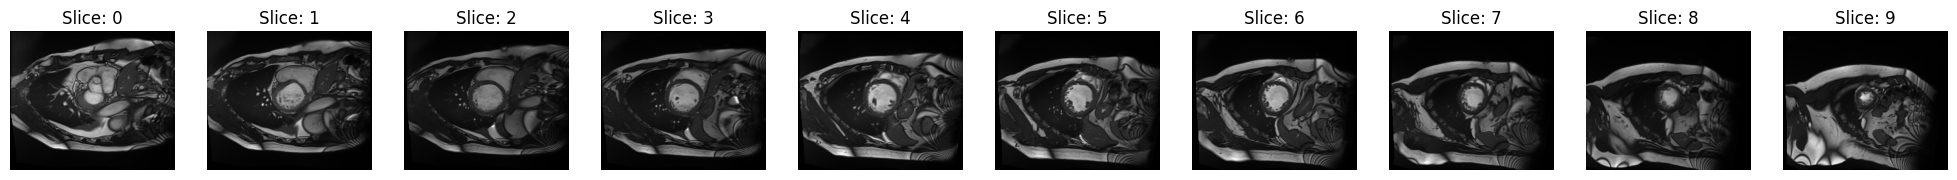

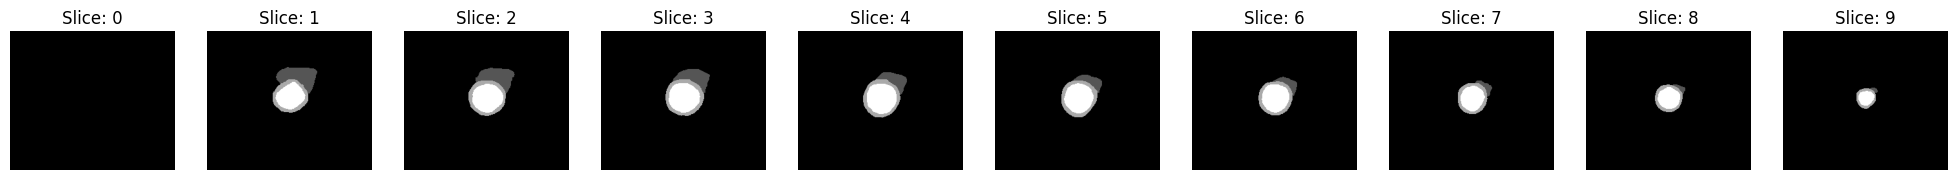

In [ ]:
# Show images and masks
patient = 0
example_image = pre.heart_mask_loader( [ images_train_ED_path[patient] ] )
example_mask = pre.heart_mask_loader( [ masks_train_ED_path[patient] ] )
pre.visualize_image_mask(*example_image, *example_mask, example_image[0].shape[2])

Comparing the data of different patients, it can be observed that the relative position of the left and right ventricles varies. Therefore, in order to remove this source of variability, the 3D segmentation masks are rotated so that those structures are horizontally aligned, with the LV on the left and the RV on the right. This is done by the method ```align_heart_mask``` implemented on *preprocessing.py*. Essentially a line between the center of those two heart strutures is identified and its angle with the horizontal axis is computed, the image is then rotated by the negative of that value.

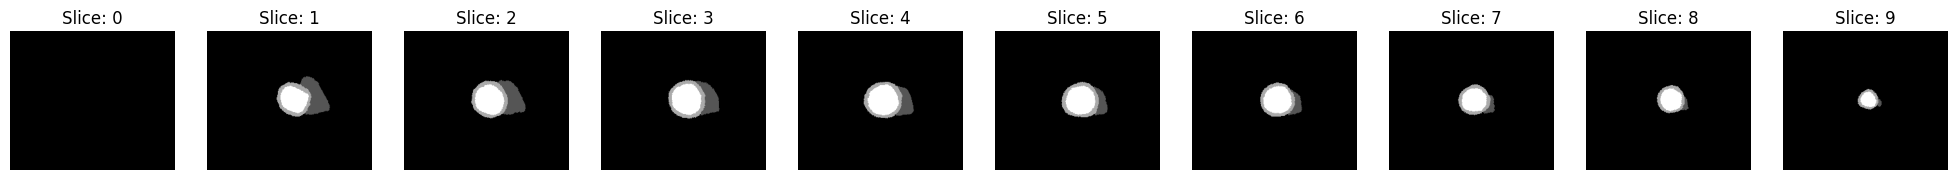

In [ ]:
# Rotate masks so that the relative position of the LV and RV is always the same
example_mask = pre.align_heart_mask( example_mask )
pre.visualize_mask( *example_mask )

Also, the MRI scans include structures other than the LV, RV and MY, resulting in a large useless background area in the segmentation masks. Therefore the 3D segmentation masks are cropped to the smallest square containing the heart structures of interest, furthermore, black slices are discarded, this is done by the method ```crop_heart_mask``` implemented on *preprocessing.py*.

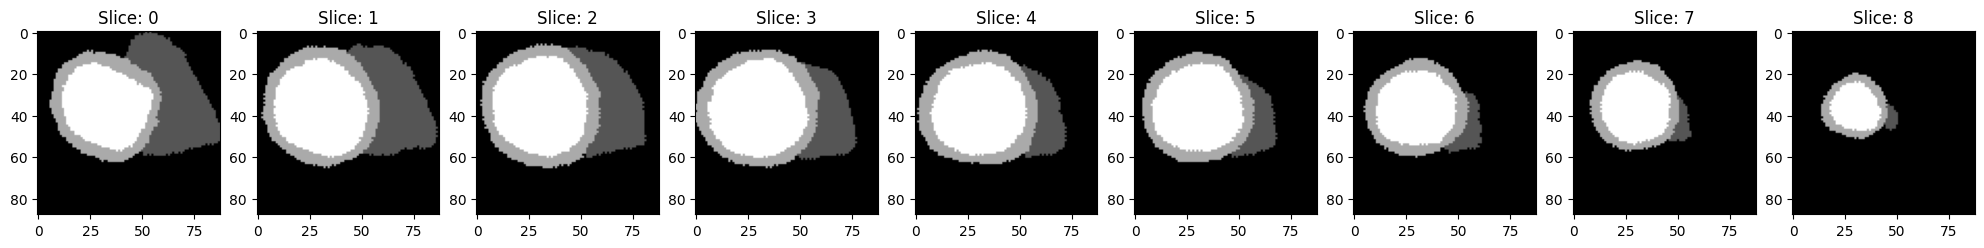

In [ ]:
# Crops masks
example_mask = pre.crop_heart_mask( example_mask )
pre.visualize_mask( *example_mask, show_axis=True )

However, the cropping process results in segmentation masks of different sizes and the size of the input images of the VAE must be standardized. To solve this issue, the segmentation masks are either downsampled or upsampled using the nearest neighbour interpolation method so that each frame is of size $128 \times 128$, this is done by the method ```resize_heart_mask``` implemented on *preprocessing.py*.

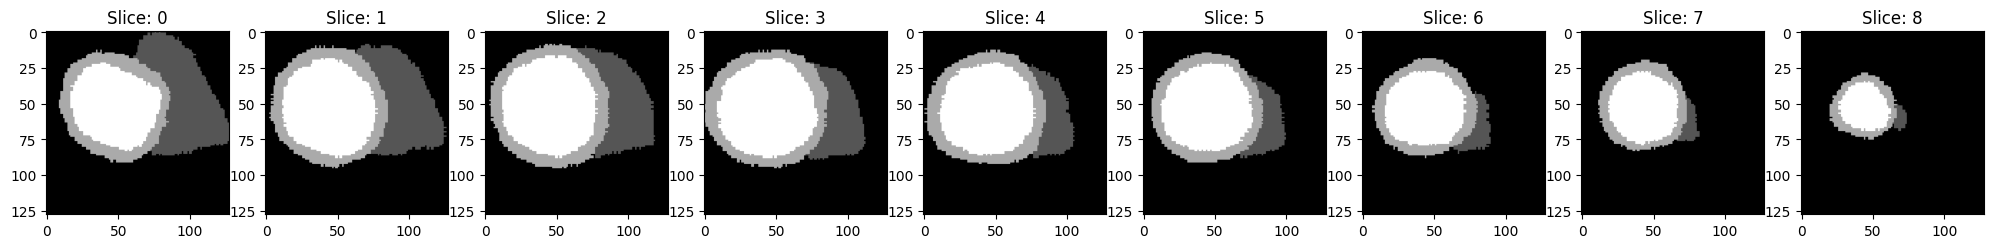

In [ ]:
# Standardize image size (inputs of the network must be of same size)
example_mask = pre.resize_heart_mask( example_mask )
pre.visualize_mask( *example_mask, show_axis=True )

Before transforming the 3D masks into independent 2D masks, all slices were labeled from $0$ to $1$, with fractional values for the slices in between, in order to able to use the slice position information later on. This is done by the method ```label_slices``` implemented on *preprocessing.py*, an example is shown below.

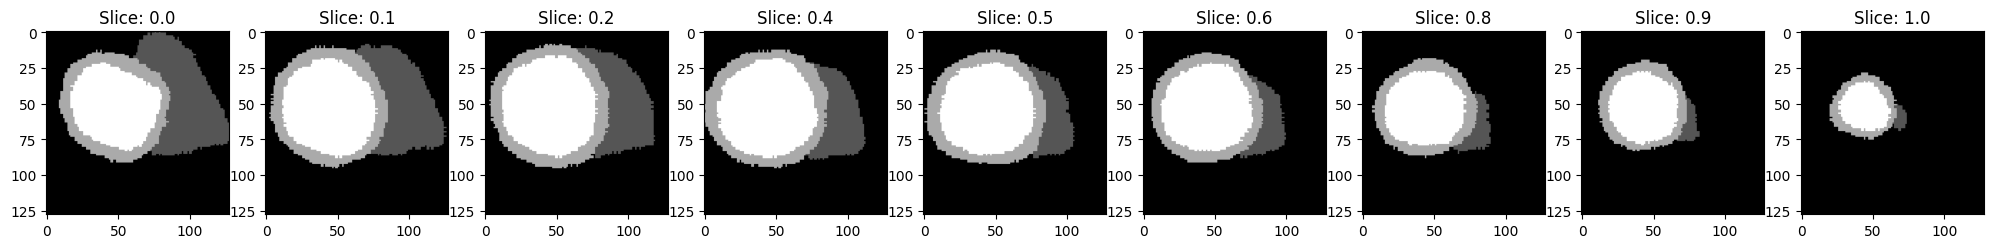

In [ ]:
# Give a label for the each slice
masks_labels = np.array(pre.label_slices(example_mask))
pre.visualize_mask( *example_mask, show_axis=True, labels=masks_labels[:,1])

Once the 3D segmentation masks are aligned and cropped and their sizes standardized, their frames are decoupled (this is done by the method ```convert_3D_to_2D``` implemented on *preprocessing.py*.) and treated as independent 2D images.

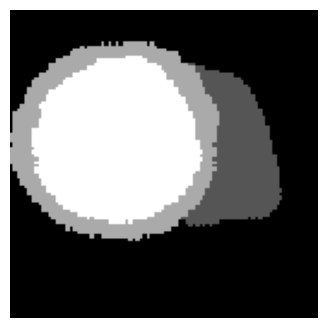

In [ ]:
# Separate the frames, each frame will treated as a 2D image
example_mask = pre.convert_3D_to_2D(example_mask)

idx = 3
pre.visualize_2d_mask(example_mask[idx])

Up to this point, the images are 2D segmentation masks with labels 0, 1, 2 and 3 corresponding to the background, RV, MY and LV, respectively. However it is necessary to have a one-hot encoding of the segmentation mask, i.e., one binary mask per channel. This transformation of the encoding is done by the method ```heart_mask_extraction``` inplemented on *preprocessing.py*.

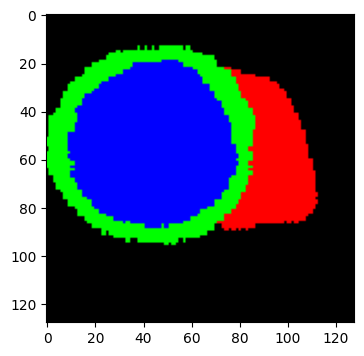

In [ ]:
# Translate multilabel mask into multi channel mask (each channel represents a different structure),
# the axis are ordered according to PyTorch standard: (channel, height, width)
example_mask = pre.heart_mask_extraction(example_mask)
pre.visualize_multichannel_mask( example_mask[idx] )

All those pre-processing steps are combined on the method ```preprocessingPipeline```, implemented on *preprocessing.py*, that allows their efficient application to the entirety of the dataset. The resulting arrays are passed to a PyTorch DataLoader in order to be used to train and test the VAE.

In [44]:
data, masks_labels = pre.preprocessingPipeline(masks_train_ED_path + masks_test_ED_path)

In [7]:
# Saving the pre-processed dataset
pre.saveDataset(data, path+'./', 'ED_data')
pre.saveDataset(masks_labels, path+'./', 'masks_labels')

In [8]:
# Loading the pre-processed dataset
data = pre.loadDataset(path+'./', 'ED_data')
masks_labels = pre.loadDataset(path+'./', 'masks_labels')

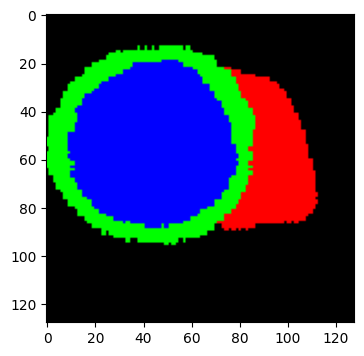

In [9]:
# Check that the data was correctly imported
test_idx = 3
pre.visualize_multichannel_mask(data[test_idx])

## VAE

A Variational Autoencoder (VAE) is a probabilistic generative model that learns to encode and decode data, allowing for the generation of new samples that resemble the training data. It consists of an encoder network, a decoder network, and a latent space representation. The architecture of the VAE is implemented in the class ```VAE``` on the file *model.py* and is inspired by that of Painchaud, N., et al. [2].

The general architecture of a VAE is illustrated in the figure bellow.

![VAE](images/image_vae.png)

Where $Z$ is the latent space representation given by:
$$Z = \mu + \sigma \epsilon$$
$$\epsilon \sim \mathcal{N}(0, I)$$

The encoder network takes as input an image and transforms it into a lower-dimensional representation in the latent space. In our implementation, the encoder consists of four convolutional blocks, followed by two fully connected layers that output $\mu$ and $\sigma$. Each convolutional block is composed of a $2 \times 2$ convolutional layer of stride $2$ followed by a $3 \times 3$ convolutional layer of stride $1$. The number of output channels for the first layer is $48$ and it is duplicated by the first layer of each successive block. Finally, the dimensionality of the latent space was fixed at $32$.

These convolutional layers extract relevant features from the input image, while the fully connected layers map these features to the mean, $\mu$, and log variance, $\log \sigma^2$, of the latent space distribution, which are then used to sample a point $Z$ in the latent space.

One point to be considered during the implementation of the architecture was how to compute the input dimension of the fully connected layers. Knowing that the input of the fully connected layers is the flattened output of the convolutional layers of the encoder, to compute the necessary dimension a meta tensor is passed through the convolutional layers of the encoder and the resulting dimension can be obtained directly.  This is done using the function `compute_fc_input_dim`, implemented on *model.py*.


The decoder network takes a point $Z$ in the latent space as input and reconstruct the original image from it. In our implementation, it mirrors the architecture of the encoder network, therefore it consists in a fully connected layer followed by four convolutional blocks. Each convolutional block is composed of a $2 \times 2$ transpose convolutional layer of stride $2$ followed by a $3 \times 3$ transpose convolutional layer of stride $1$. The number of output channels is halved by the second layer of each convolutional block and reaches $48$ before the last block. The final convolutional layer has softmax activation, giving, for each pixel, the probability of belonging to each channel.


The VAR is trained to minimize the sum of the reconstruction error between the original image (encoder input) and the reconstructed image (decoder output) and the KL divergence between the imposed Gaussian prior distribution $p_{\theta}(z)$ and the approximate a posteriori distribution $q_{\phi}(z|x)$.

To measure the reconstruction error, we use the soft Dice loss, which is the measure of the overlap between two samples: the predicted and the ground truth masks. The soft Dice Loss is defined as:

$$L_D(x,\hat x) = 1 - \frac{2 \sum_{i=1}^{N} x_i \hat x_i + \epsilon}{\sum_{i=1}^{N} \left| x_i \right| + \sum_{i=1}^{N} \left| \hat x_i \right| + \epsilon}$$

Where $u_i$ and $v_i$ are the predicted and ground truth values, respectively, and $\epsilon$ is a small constant to avoid division by zero. The soft Dice loss was preferred over the cross-entropy loss because the denominator of the first has the effect of normalizing the loss according to the size of the mask, therefore it leads to better results when there is class imbalance in the masks.

Additionally, the Kullback-Leibler Divergence (KLD) loss is used to encourage the latent space distribution to resemble a Gaussian distribution. The KLD loss is defined as:

$$L_{KLD}(\mu, \sigma) = \frac{1}{2} \sum_{i=1}^{d} (\mu_i^2 - \sigma_i^2 - 1 - log(\sigma_i^2))$$

Where $\mu, \sigma \in \mathbb{R}^d$ are the mean and standard deviation of the latent space distribution, respectively, and $d$ is the size of the latent space.

Furthermore, a trade-off hyperparameter $\lambda$ was introduced to control the influence of each term on the loss:
$$L(x, \hat x, \mu, \sigma) = L_D(x, \hat x) + \lambda L_{KLD}(\mu, \sigma)$$

The VAE was trained with the following parameters:

- batch size (`batch_size`): $64$
- latent space dimension (`z_dim`): $32$
- loss trade-off hyperparameter (`lamb`): $\lambda = 10^{-5}$
- learning rate of the Adam optimizer (`learning_rate`): $6\cdot 10^{-5}$ (as used by Painchaud, N., et al. [2])
- L2 penalty (`l2`): $0.01$

Different values of the hyperparameter $\lambda$ were tested, with $\lambda = 10^{-5}$ giving the best results. A comparison between the results for different values is done in the following sections.

The training of the VAE is done in the cells bellow.

In [10]:
# Decide in which device we want to run on
if (torch.cuda.is_available()):
  device = torch.device("cuda:0")
else:
  device = "cpu"

print("Running on", device)

Running on cuda:0


In [50]:
batch_size = 64

# Create datasets that contain tensors for features and labels
tensor_dataset = torch_data.TensorDataset(torch.Tensor(data), torch.Tensor(masks_labels))

# Define train, validation and test sets
torch.manual_seed(0)
train_set, val_set, test_set = torch_data.random_split(tensor_dataset, [0.6, 0.2, 0.2])

# Separate the labels and the data
train_data, train_labels = train_set[:]
val_data, val_labels = val_set[:]
test_data, test_labels = test_set[:]

# Define the data loaders
train_loader = torch_data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = torch_data.DataLoader(val_data, batch_size=batch_size, shuffle=True)
test_loader = torch_data.DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [51]:
# Define the dimensions of the input space
n_channels = 4
n_rows = n_cols = train_data[0].shape[-1]
z_dim = 32

# Reconstruction error vs. KLD trade-off hyperparameter
lamb = 1e-5

# Create an instance of the VAE model
model = m.VAE(n_rows, n_cols, n_channels, z_dim, lamb).to(device)

In [52]:
# Define the optimizer
learning_rate = 6e-5
l2 = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=l2)

In [53]:
num_epochs = 100
train_loss = []
val_loss = []
for epoch in range(num_epochs):
    new_train_loss, new_val_loss = model.train_one_epoch(optimizer, train_loader, val_loader, epoch=epoch, device=device)
    train_loss.append(new_train_loss)
    val_loss.append(new_val_loss)

Epoch: 0	Average train loss: 0.8023
		Average validation loss: 0.7981
Epoch: 1	Average train loss: 0.7985
		Average validation loss: 0.7935
Epoch: 2	Average train loss: 0.7901
		Average validation loss: 0.7821
Epoch: 3	Average train loss: 0.7738
		Average validation loss: 0.7684
Epoch: 4	Average train loss: 0.7668
		Average validation loss: 0.7591
Epoch: 5	Average train loss: 0.7341
		Average validation loss: 0.6570
Epoch: 6	Average train loss: 0.6110
		Average validation loss: 0.5676
Epoch: 7	Average train loss: 0.5666
		Average validation loss: 0.5451
Epoch: 8	Average train loss: 0.5460
		Average validation loss: 0.5222
Epoch: 9	Average train loss: 0.5212
		Average validation loss: 0.4984
Epoch: 10	Average train loss: 0.4968
		Average validation loss: 0.4791
Epoch: 11	Average train loss: 0.4656
		Average validation loss: 0.4320
Epoch: 12	Average train loss: 0.4077
		Average validation loss: 0.3628
Epoch: 13	Average train loss: 0.3327
		Average validation loss: 0.2908
Epoch: 14	Averag

In [54]:
# Save model so that we don't have to retrain every time
torch.save(model.state_dict(), path+'./model_{}.pt'.format(str(lamb)))

In [55]:
# Load saved model
lamb = 1e-5
model = m.VAE(lamb=lamb).to(device)
model.load_state_dict(torch.load(path+'./model_{}.pt'.format(str(lamb)), map_location=device))

<All keys matched successfully>

To assess the model's performance, the train and validation losses are plotted below on the same graph. The final test loss is also computed.

Total epochs:  100


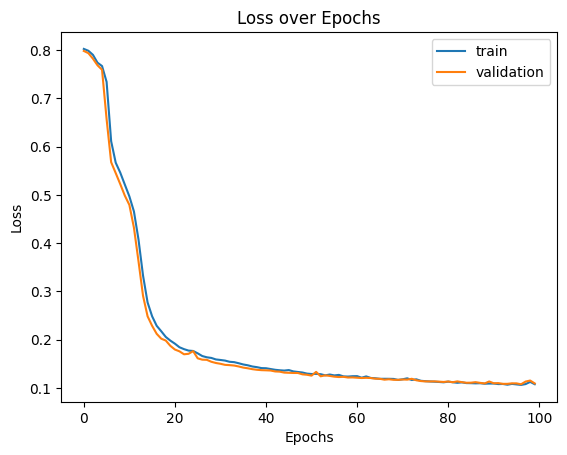

Test loss:  0.12104186738372609


In [56]:
# Plot train and validation losses...
eval.plot_loss(train_loss, val_loss)
# ... and evalutate test loss
test_loss = model.compute_test_loss(test_loader, device)
print( "Test loss: ", test_loss )
# save all losses
eval.save_loss(train_loss, val_loss, test_loss, path, str(lamb))

It is possible to observe that both the train and validation losses decrease over time and are very cose to each other, which indicates that the model learns to generalize well (doesn't overfit to the training data) and that it is able to reconstruct the images from the latent space. This is confirmed by the test loss, that is also close to the train and validation losses for the trained model.

| $\lambda$ | Train loss | Validation loss | Test loss |
| :--: | :--: | :--: | :--: |
| $10^{-5}$ | 0.11 | 0.12 | 0.12 |

## Results

In this section the reconstruction results for the trained VAE will be analised, as well as its data generation capability. Finally, the distribution of the data on the latent space will be inspected.

### Data reconstruction

In this section, the reconstruction results obtained with the VAE defined on the previous section are shown.

Below, the original segmentation masks and the corresponding reconstruction obtained with the trained model are displayed for some test samples. The dice loss for each pair is also computed.

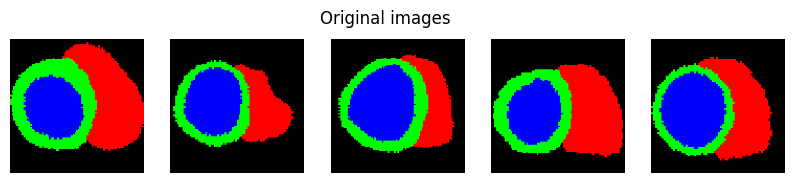

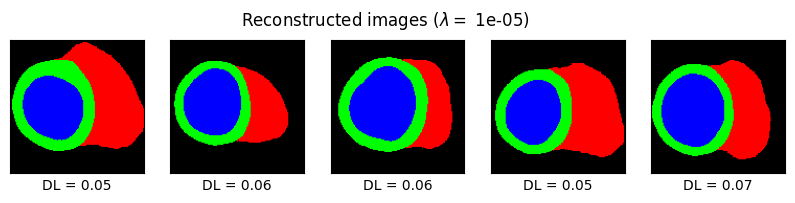

In [ ]:
# Load saved model
lamb = 1e-5
model = m.VAE(lamb=lamb).to(device)
model.load_state_dict(torch.load(path+'./model_{}.pt'.format(str(lamb)), map_location=device))

# Visualize test set reconstruction
test_examples = next(iter(test_loader))[:5]
eval.visualize(model, test_examples, device=device)

To better understand and quality of the reconstructions obtained with the VAE, the best and worst reconstructions obtained on the test set are displayed. The method `sorted_recon_losses`, implemented in *model_evaluation.py*, evaluates the quality of the resconstructed images according to the soft dice loss and returns the indices sorted according to the quality of the reconstruction.

In [ ]:
recon_losses, original_images, reconstructed_images, indices = eval.sorted_recon_losses(model, test_loader, device)

Below the best reconstructions are shown. It can be seen that the model is able to preserve the main characteristics of the cardiac structures.

Best Recontructions:


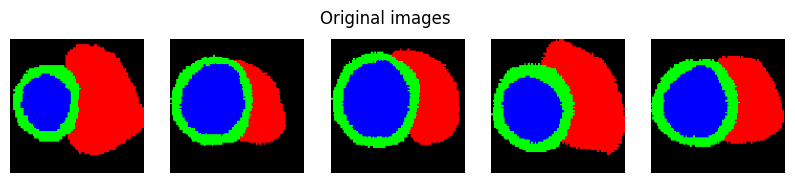

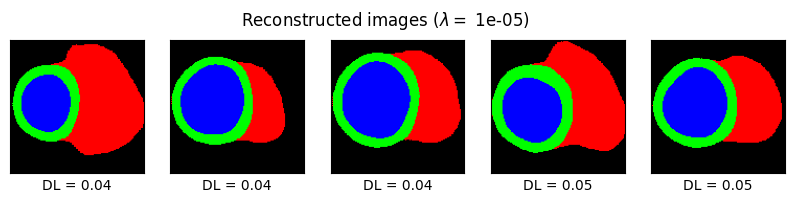

In [ ]:
# Visualize test set reconstruction (best reconstructions)
print("Best Reconstructions:")
data_best = original_images[indices[:5]]
eval.visualize(model, data_best, device=device)

The worst reconstructions are exhibited below. From the best and worst reconstructions it seems that the model can better reconstruct slices closer to the middle of the heart, this hypothesis will be investigated in the next section.

Worst Recontructions:


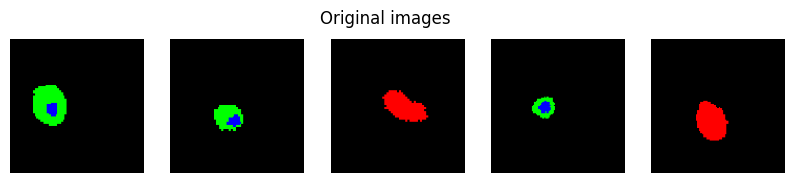

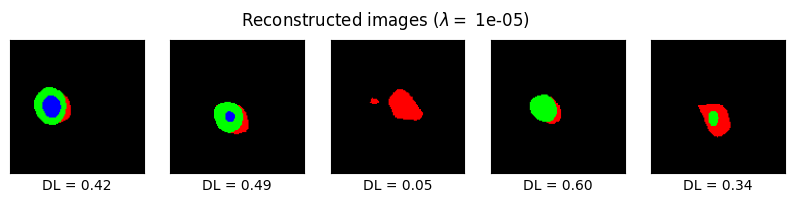

In [ ]:
# Visualize test set reconstruction (worst reconstructions)
print ("Worst Recontructions:")
data_worst = original_images[indices[-5:]]
eval.visualize(model, data_worst, device=device)

### Evaluate average error

Assessing the mean error for each category of slices provides a valuable approach to investigate potential variations in the VAE's proficiency in generating specific types. Based on the findings presented below, it is observed that the Soft Dice Loss exhibits higher values for lower slices. This outcome can be attributed to the inherent difficulty faced by the VAE in accurately reconstructing intricate details within images containing a considerable amount of content.

In [57]:
# Load saved model
lamb = 1e-5
model = m.VAE(lamb=lamb).to(device)
model.load_state_dict(torch.load(path+'./model_{}.pt'.format(str(lamb)), map_location=device))

<All keys matched successfully>

In [102]:
# Retrieve the labels from lower, middle and upper slices
test_data_list = eval.transform_tensor_list(test_data)
test_labels_list = eval.transform_tensor_list(test_labels)

i_lower, i_middle, i_upper, o_lower, o_middle, o_upper = eval.retrieve_2D_labeled_images(model, test_data_list, test_labels_list, device)

# Compute losses
loss_lower = eval.compute_loss_slices(torch.Tensor(i_lower), torch.Tensor(o_lower), model)
loss_middle = eval.compute_loss_slices(torch.Tensor(i_middle), torch.Tensor(o_middle), model)
loss_upper = eval.compute_loss_slices(torch.Tensor(i_upper), torch.Tensor(o_upper), model)

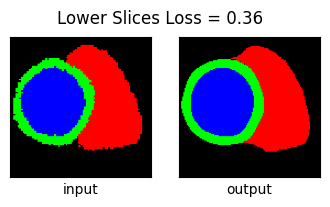

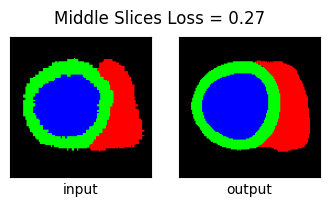

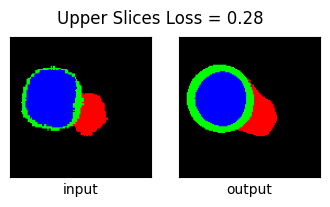

In [105]:
# Visualize some images
idx = 20

eval.visualize_images_slices(i_lower[idx], o_lower[idx], loss_lower, 'Lower')
eval.visualize_images_slices(i_middle[idx], o_middle[idx], loss_middle, 'Middle')
eval.visualize_images_slices(i_upper[idx], o_upper[idx], loss_upper, 'Upper')

### Data generation and latent space analysis

Other than the reconstruction quality, the VAE must also be analised as a generative model. The loss that is being minimized during training is:
$$L\left( \left( x^{(i)}, \hat x^{(i)}, \mu^{(i)}, \sigma^{(i)} \right)_{i=1}^{n} \right) = \frac{1}{n} \sum_{i=1}^{n} L_D(x^{(i)}, \hat x^{(i)}) + \lambda \frac{1}{n} \sum_{i=1}^{n} L_{KLD}(\mu^{(i)}, \sigma^{(i)})$$
As explained before, $\lambda$ is a trade-off parameter that controls the influence of each term in the loss.

In order to obtain good reconstruction results, it was necessary to set a small value for $\lambda$ ($\lambda = 10^{-5}$). However, a VAE can be used as a generative model due to the probabilistic modelling of the latent space through the KL divergence term in the loss function.

For such a low weight of the KL divergence term it can be suposed that the model will not be able to generate realistic masks when sampling the latent space from a Gaussian distribution. Indeed, doing so and displaying the generated images in the cell bellow, it can be seen that the output does not resemble heart segmentation masks.



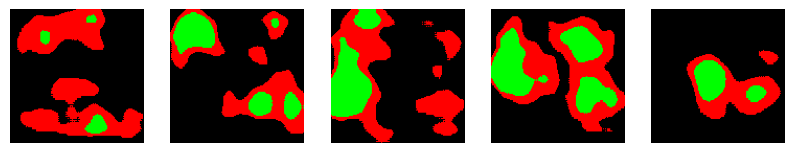

In [ ]:
# Load saved model
lamb = 1e-5
model = m.VAE(lamb=lamb).to(device)
model.load_state_dict(torch.load(path+'./model_{}.pt'.format(str(lamb)), map_location=device))

# Generate new images
_, generated_images = model.generate_images(5, device)
eval.visualize_generated_images(generated_images)

In view of the bad quality of the generated images, the VAE was trained for different values of $\lambda$ and the reconstruction and generation results were compared. The train, validation and test losses were:

| $\lambda$ | Train loss | Validation loss | Test loss |
| :--: | :--: | :--: | :--: |
| $10^{-5}$ | 0.11 | 0.12 | 0.12 |
| $10^{-4}$ | 0.12 | 0.13 | 0.13 |
| $10^{-3}$ | 0.44 | 0.44 | 0.43 |
| $10^{-2}$ | 0.30 | 0.26 | 0.25 |
| $10^{-1}$ | 0.61 | 0.62 | 0.62 |
| $1$       | 0.40 | 0.50 | 0.50 |


The reconstruction results for a same set of test images are shown bellow as well as the dice loss for each.

![VAE](images/input_lamb1.png)
![VAE](images/output_lamb1.png)
![VAE](images/output_lamb0.1.png)
![VAE](images/output_lamb0.01.png)
![VAE](images/output_lamb0.001.png)
![VAE](images/output_lamb0.0001.png)
![VAE](images/output_lamb1e-05.png)


Sampling the latent space according to a Gaussian distribution of zero mean and identity covariance matrix, the following results were obtained for different values of $\lambda$.

![VAE](images/generated_lamb1.png)
![VAE](images/generated_lamb0.1.png)
![VAE](images/generated_lamb0.01.png)
![VAE](images/generated_lamb0.001.png)
![VAE](images/generated_lamb0.0001.png)
![VAE](images/generated_lamb1e-05.png)

In [ ]:
"""
# Train the VAE for different lambda values
lambda_list = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]
eval.evaluate_lambda(train_loader, val_loader, test_loader, lambda_list, device, path)
"""

'\n# Train the VAE for different lambda values\nlambda_list = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]\neval.evaluate_lambda(train_loader, val_loader, test_loader, lambda_list, device, path)\n'

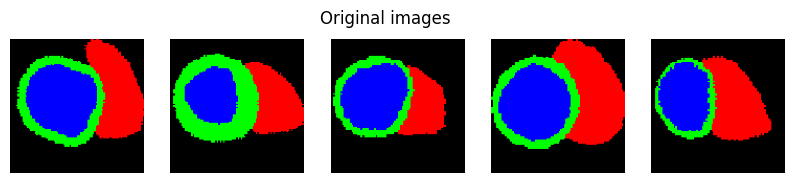

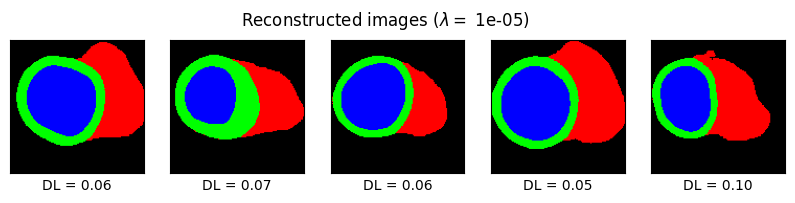

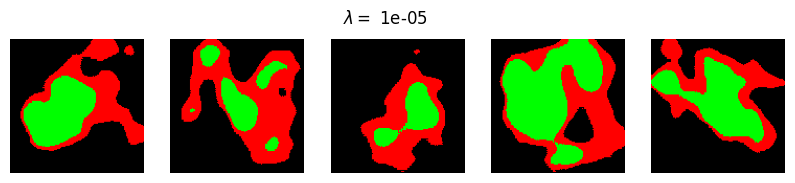

Train loss: 0.11
Validation loss: 0.12
Test loss: 0.12


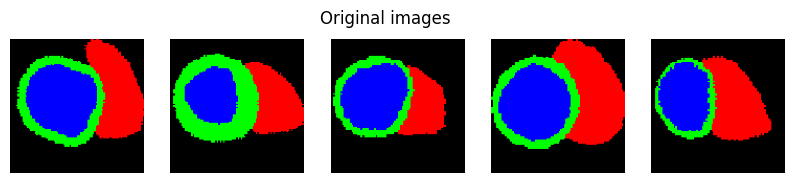

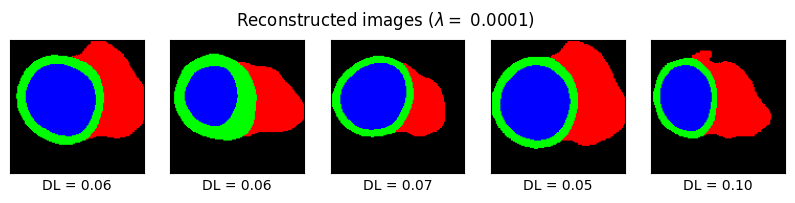

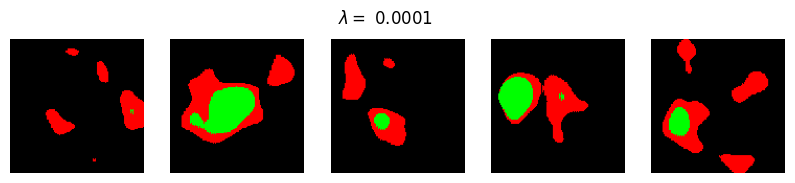

Train loss: 0.12
Validation loss: 0.13
Test loss: 0.13


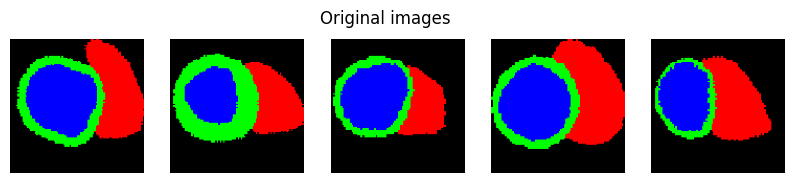

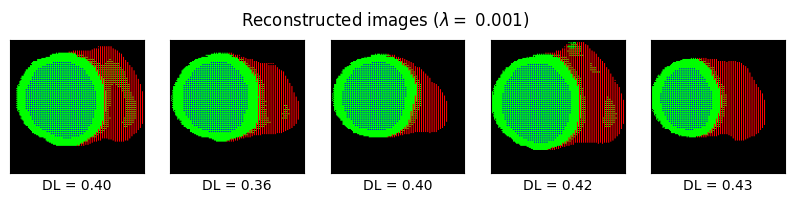

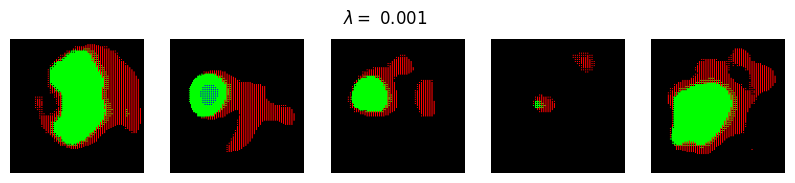

Train loss: 0.44
Validation loss: 0.44
Test loss: 0.43


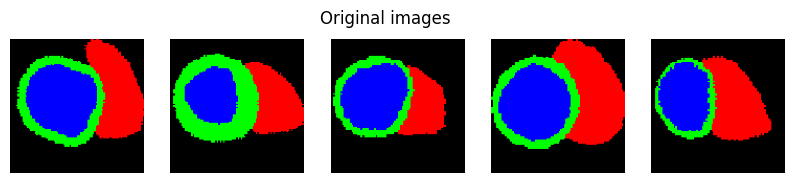

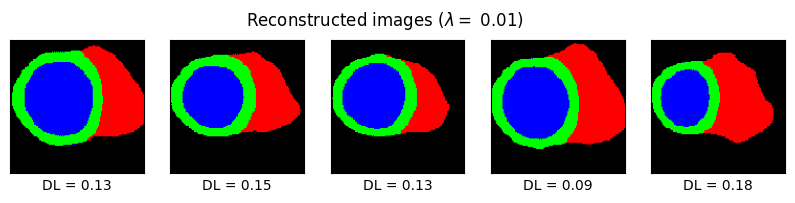

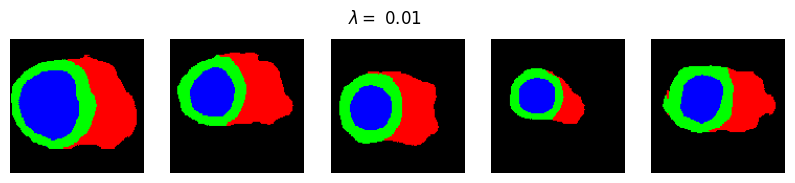

Train loss: 0.30
Validation loss: 0.26
Test loss: 0.25


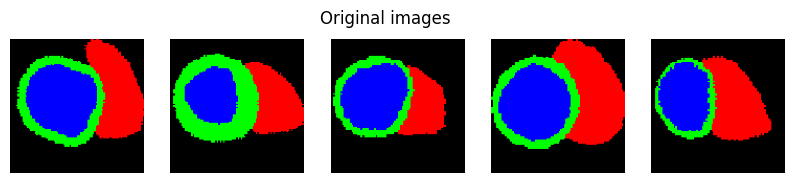

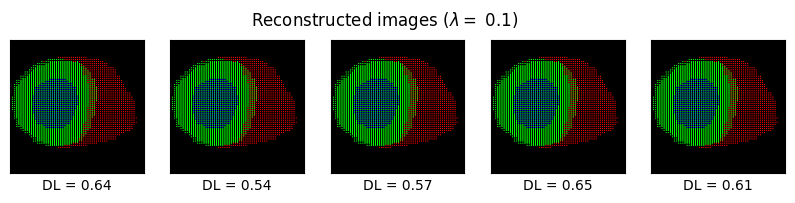

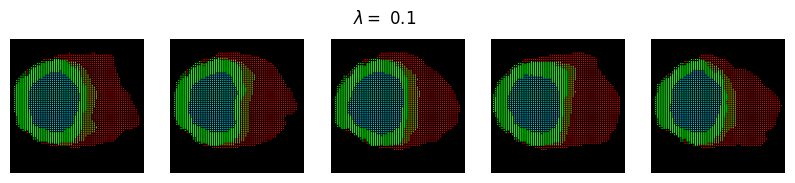

Train loss: 0.61
Validation loss: 0.62
Test loss: 0.62


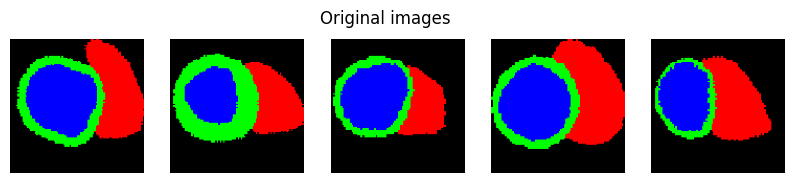

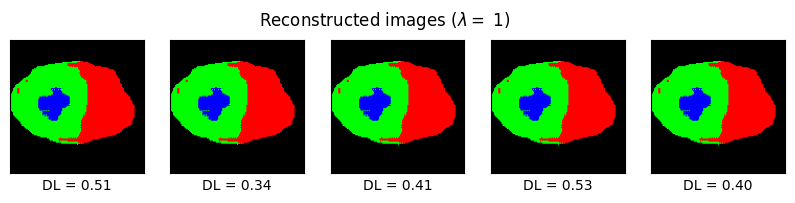

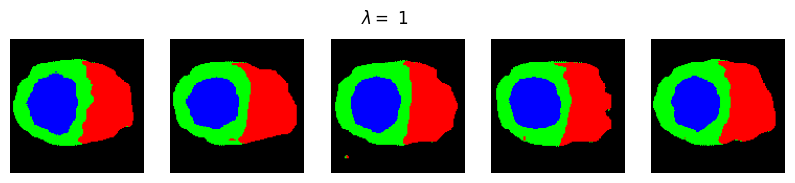

Train loss: 0.40
Validation loss: 0.50
Test loss: 0.50


In [ ]:
"""
# Display results for different values of lambda
lambda_list = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]
data = next(iter(test_loader))[:5]
for lamb in lambda_list:

  # Load saved model
  model = m.VAE(lamb=lamb).to(device)
  model.load_state_dict(torch.load(path+'./model_{}.pt'.format(lamb), map_location=device))

  # Visualize test set reconstruction
  eval.visualize(model, data, device=device, save=True, path=path)

  # Generate new images
  _, generated_images = model.generate_images(5, device)
  eval.visualize_generated_images(generated_images, save=True, path=path, lamb=lamb)

  # Get reconstruction losses
  train_loss, val_loss, test_loss = eval.load_loss(path, str(lamb))
  for name, loss in zip( ['Train', 'Validation', 'Test'], [train_loss[-1], val_loss[-1], test_loss] ):
    print( "{} loss: {:.2f}".format(name, loss) )
"""

It can be seen that as the value of $\lambda$ increases, the reconstruction results deteriorate while the generated images more closely resemble cardiac segmentation maps. Notice that for $\lambda=1$ the VAE always reconstructs a same image (at test time $Z$ is set to $Z=\mu$). In view of the varying quality of reconstruction as a function of $\gamma$ it is interesting to analise how close the latent space distribution is to $\mathcal{N}\left(0,I\right)$. To do so, the empirical mean vector and covariance matrix of the latent space representation of the training data are computed and displayed, $Z$ is taken as $Z = \mu$.

For larger values of $\lambda$, the empirical mean is closer to zero, however the covariance matrix is practically zero as well, which explains the fact that the reconstructed image is always the same. For small values of $\lambda$ it can be seen that the mean vector is far from zero, which explains the fact that image generation does not work well when sampling the latent space from $\mathcal{N}\left(0,I\right)$.

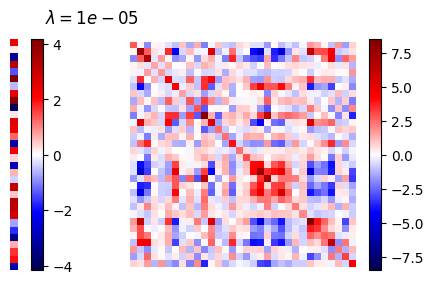

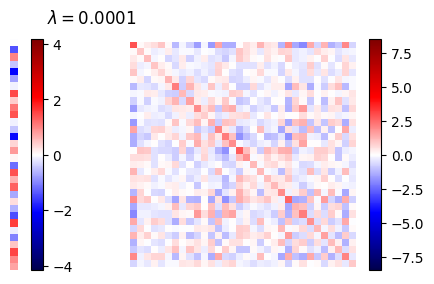

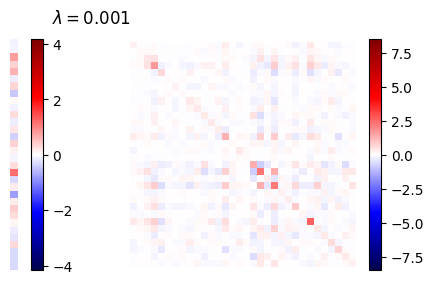

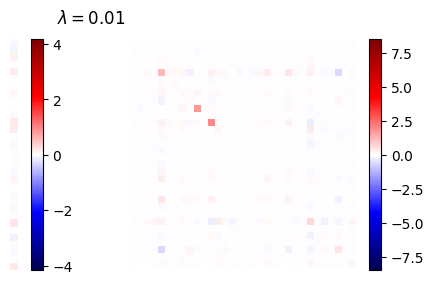

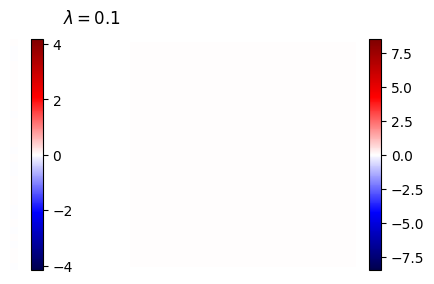

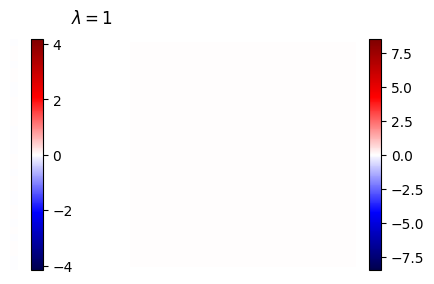

In [ ]:
lambda_list = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]
eval.fit_multivariate_gaussian( lambda_list, train_loader, path, device )

### Clustering

In [ ]:
# Generate mu and logvar
mus, logvars = eval.generate_latent(model, train_loader, device)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


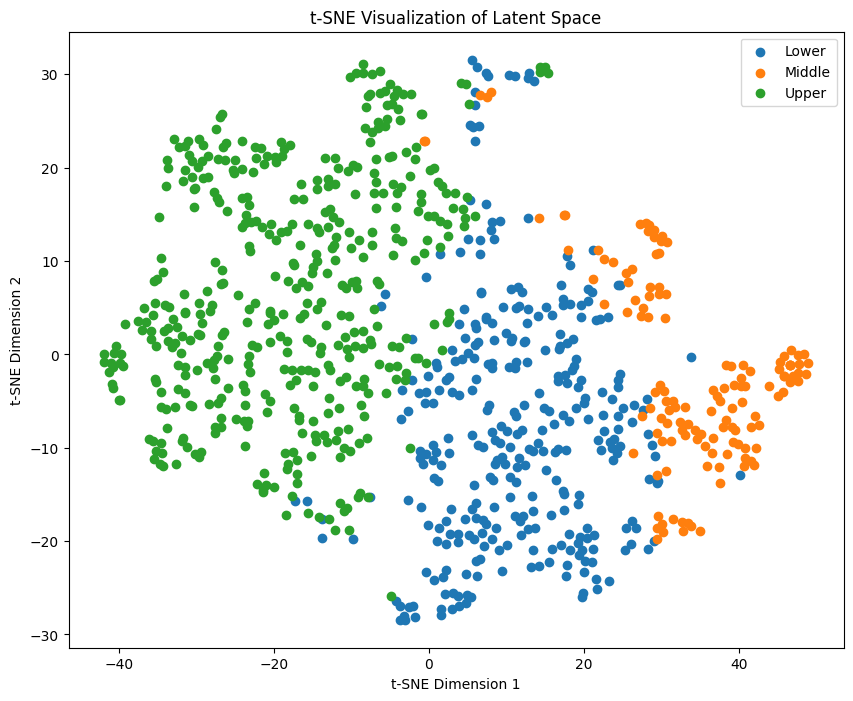

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

# Move tensors from GPU to CPU
mus_cpu = mus.cpu().detach().numpy()
logvars_cpu = logvars.cpu().detach().numpy()

# Concatenate mu and logvar
latent_data = np.concatenate([mus_cpu, logvars_cpu], axis=1)

# Reduce dimensions using t-SNE
tsne = TSNE(n_components=2, random_state=42)
latent_tsne = tsne.fit_transform(latent_data)

# Clusterize the latent data
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(latent_data)

# Assign labels to the clusters
labels = ['Lower', 'Middle', 'Upper']

# Plot the t-SNE representation with cluster labels
plt.figure(figsize=(10, 8))
for i in range(len(labels)):
    plt.scatter(latent_tsne[clusters == i, 0], latent_tsne[clusters == i, 1], label=labels[i])
plt.legend()

plt.title('t-SNE Visualization of Latent Space')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()